## Business Case: Optimizing Spare Parts Inventory Management
Maintaining adequate inventory levels of spare parts across multiple service centers to meet market demand presents a persistent challenge. Service centers incur substantial costs in managing spare parts inventory, yet ensuring the availability of these parts remains a critical issue.

## Project Objective:
Develop a predictive inventory forecasting model to enable service centers to meet Just-In-Time (JIT) standards efficiently.

## Contents

- [Import Stuff](#import-stuff)
- [Load the Data](#load-the-data)
- [Basic EDA](#basic-eda)
- [Data Preprocessing](#data-preprocessing)
- [Advanced EDA](#advanced-eda)
- [Time Series Analysis](#time-series-analysis)
- [Time Series Forecasting](#time-series-forecasting)
- [Model Evaluation](#models-evaluation)
- [Multivariate Analysis](#induct-exogenous-variable-in-sarimax-model)

## Import Stuff

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

## Load the Data

In [2]:
# loading data
data = pd.read_csv("inventory.csv")

In [3]:
# size of data
data.shape

(28482, 7)

In [4]:
# getting first 10 records
data.head(10)

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL
5,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CHAIN LUBRICATION
6,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,4 WAY SWITCH
7,31-05-17,31-05-17,pattXXXXXXXXXX,KA53EMXXXX,BAJAJ PLATINA,3717,ENGINE OIL
8,31-05-17,31-05-17,pattXXXXXXXXXX,KA53EMXXXX,BAJAJ PLATINA,3717,3M OIL
9,31-05-17,31-05-17,pattXXXXXXXXXX,KA53EMXXXX,BAJAJ PLATINA,3717,CHAIN LUBRICATION


## Basic EDA

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  int64 
 6   invoice_line_text      28448 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.5+ MB


In [9]:
# Checking for null values
data.isnull().sum()

invoice_date              0
job_card_date             0
business_partner_name     0
vehicle_no                0
vehicle_model             0
current_km_reading        0
invoice_line_text        34
dtype: int64

In [10]:
100* data.isnull().sum()/data.shape[0]

invoice_date             0.000000
job_card_date            0.000000
business_partner_name    0.000000
vehicle_no               0.000000
vehicle_model            0.000000
current_km_reading       0.000000
invoice_line_text        0.119374
dtype: float64

0.12% records of invoice_line_text are nulls -> so will be dropping those rows

In [11]:
data = data[pd.notnull(data.invoice_line_text)].reset_index(drop=True)
data.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [12]:
data.shape

(28448, 7)

Hnadling outliers

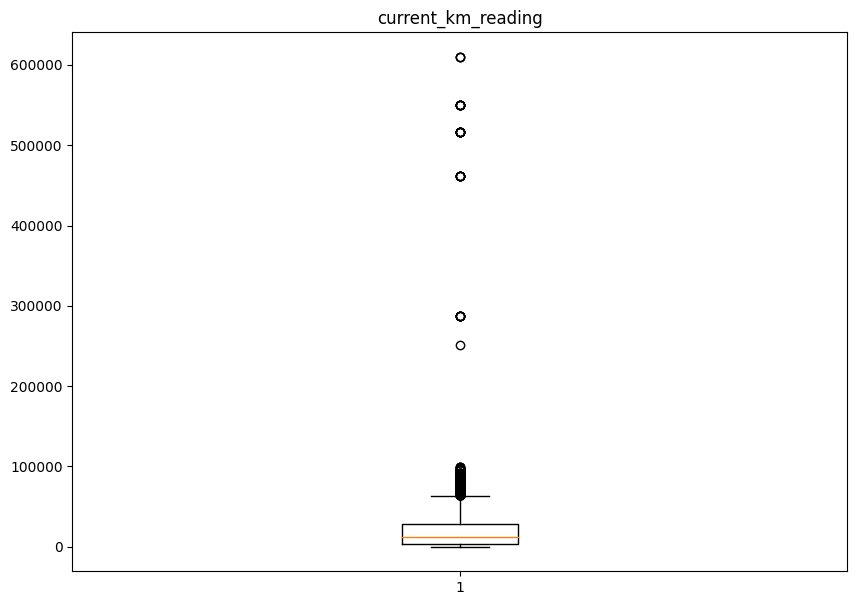

In [13]:
fig = plt.figure(figsize =(10, 7))

plt.boxplot(data.current_km_reading)
plt.title("current_km_reading")
plt.show()

Normally bikes can't exceed 100,000 km, so there is something wrong here

In [14]:
data[data.current_km_reading > 100000].shape[0]

35

In [15]:
# removing outliers
data = data[data.current_km_reading <= 100000].reset_index(drop=True)
data.shape

(28413, 7)

In [16]:
data.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [17]:
data.columns

Index(['invoice_date', 'job_card_date', 'business_partner_name', 'vehicle_no',
       'vehicle_model', 'current_km_reading', 'invoice_line_text'],
      dtype='object')

In [19]:
# dropping columns which are not important ['invoice_date','job_card_date',  'business_partner_name', 'vehicle_no']
data = data[['job_card_date', 'vehicle_model', 'invoice_line_text']]
data.shape

(28413, 3)

In [20]:
grouped_data = data.groupby(['vehicle_model'])['invoice_line_text'].count().reset_index()
grouped_data.rename(columns={'invoice_line_text': 'count'}, inplace=True)
grouped_data = grouped_data.sort_values(by='count', ascending=False)
grouped_data

,vehicle_model,count
12,BAJAJ PULSAR 150,8599
2,BAJAJ AVENGER STREET 220,4212
14,BAJAJ PULSAR 220,2654
13,BAJAJ PULSAR 180,2251
18,BAJAJ PULSAR NS 200,2203
5,BAJAJ CT 100,1432
7,BAJAJ DISCOVER 125,1345
0,BAJAJ AVENGER STREET,1111
11,BAJAJ PLATINA,843
23,BAJAJ V150,685


In [21]:
grouped_data = data.groupby(['invoice_line_text'])['vehicle_model'].count().reset_index()
grouped_data.rename(columns={'vehicle_model': 'count'}, inplace=True)
grouped_data = grouped_data.sort_values(by='count', ascending=False)
grouped_data

,invoice_line_text,count
148,ENGINE OIL,3799
76,CHAIN LUBRICATION,3437
209,GENERAL SERVICE,2136
10,AIR FILTER,1713
2,3M OIL,1628
...,...,...
369,RIM,1
370,RIM TUBLESS NECK,1
205,GEAR LEVER WELDING,1
203,GEAR LEVER OIL SEAL,1


In [22]:
data['invoice_line_text'].nunique()

502

In [23]:
# printing all items from invoice_line_text
for item in data.invoice_line_text.unique():
    print(f"'{item}',")

'ENGINE OIL',
'POLISH',
'CONSUMABLES',
'COOLANT OIL',
'CHAIN LUBRICATION',
'4 WAY SWITCH',
'3M OIL',
'GENERAL SERVICE',
'OIL FILTER',
'INDICATOR',
'HEAD REST',
'VALVE GUIDE',
'TIMMING CHAIN',
'FOOT REST',
'LOW BEAM BULB',
'VALVE GRAINDING',
'DISC PAD',
'LOADING GEAR',
'PACKING KIT',
'TIMMING CHAIN PAD',
'TENSIONER',
'CLUTCH BELL REST',
'CLUTCH ASSEMBLY',
'VALVE KIT',
'SPARK PLUG',
'ONE WAY CLUTCH',
'BORE KIT',
'AIR FILTER',
'HEAD RUBBER',
'CLUTCH CABLE',
'CRANK SHAFT',
'BRAKE ADJUSTMENT',
'BRAKE SHOE',
'AIR FILTER CHECKUP',
'DRUM BOLT WASHER',
'TANK CLEANING',
'FORK BEND',
'GEAR SHAFT',
'CLUTCH COVER GASKET',
'INDICATOR BULB',
'GEAR LEVER',
'HANDLEBAR',
'CRASH GUARD',
'FORK OIL SEAL',
'FORK OIL',
'SIDE SHIELD',
'VISIOR',
'FORK CONE SET',
'HEAD LIGHT DOOM',
'TANK ASSEMBLY',
'Clutch cable',
'DISC LEVER',
'CARBURETOR CLEANING',
'SEAT COVER',
'BUZZER',
'TAIL LAMP BULB',
'DISC OIL',
'DISC OVERHUAL',
'MASTER ASSEMBLY',
'CHAIN COVER RUBBER',
'ENGINE GUARD',
'CLUTCH CAM ',
'DOOM',
'WHEEL RUBBE

## Data Preprocessing

In [24]:
# data cleaning
data['invoice_line_text'] = data['invoice_line_text'].str.replace('BULB ', 'BULB')
data['invoice_line_text'] = data['invoice_line_text'].str.replace('OVERHUAL', 'OVERHAUL')
data['invoice_line_text'] = data['invoice_line_text'].str.replace('WIELDING', 'WELDING')
data['invoice_line_text'] = data['invoice_line_text'].str.replace('ENGINE OIL TOPUP', 'ENGINE OIL')
data['invoice_line_text'] = data['invoice_line_text'].str.replace('ASSEBLY', 'ASSEMBLY')
data['invoice_line_text'] = data['invoice_line_text'].str.replace('GRIP HANDLE', 'HANDLE GRIPPER')
data['invoice_line_text'] = data['invoice_line_text'].str.replace('HANDLEBAR', 'HANDLE BAR')
data['invoice_line_text'] = data['invoice_line_text'].str.replace('NUMBER PLATE WITH STICKERS', 'NUMBER PLATE')

In [25]:
service_related_tokens = [
'OVERHAUL',
'WELDING',
'SERVICE',
'WORK',
'PUNCHER',
'REBORE',
'DENT',
'RC CARD',
'TAX',
'ENGINE WORK',
'CHECK',
'LABOUR',
'CHARGE',
'FEES',
'PAYMENT',
'STICKERS'
'ADJUSTMENT',
'REGISTOR',
'INSURANCE',
'ADJUSTMENT',
'REMOVAL',
'THREADING',
'CLEANING',
]
services = []
for item in data.invoice_line_text.unique():
    try:
        if sum([item.find(token)!= -1 for token in service_related_tokens]) > 0:
            services.append(item)
    except:
        print(item)

need_to_be_removed_in_services = [
'PETROL',
'VALVE GRAINDING',
'CHAIN LUBRICATION',
'ENGINE RE CONDITION',
'HEAD LIGHT WIRING',
'EX SHOW ROOM'
]
services.extend(need_to_be_removed_in_services)

In [26]:
len(services)

67

In [27]:
for item in data.invoice_line_text.unique():
#      if item not in services and item.find('EX SHOW ROOM')!=-1:
    if item not in services:
        print(item)
#         print(f"'{item}',")

ENGINE OIL
POLISH
CONSUMABLES
COOLANT OIL
4 WAY SWITCH
3M OIL
OIL FILTER
INDICATOR
HEAD REST
VALVE GUIDE
TIMMING CHAIN
FOOT REST
LOW BEAM BULB
DISC PAD
LOADING GEAR
PACKING KIT
TIMMING CHAIN PAD
TENSIONER
CLUTCH BELL REST
CLUTCH ASSEMBLY
VALVE KIT
SPARK PLUG
ONE WAY CLUTCH
BORE KIT
AIR FILTER
HEAD RUBBER
CLUTCH CABLE
CRANK SHAFT
BRAKE SHOE
DRUM BOLT WASHER
FORK BEND
GEAR SHAFT
CLUTCH COVER GASKET
INDICATOR BULB
GEAR LEVER
HANDLE BAR
CRASH GUARD
FORK OIL SEAL
FORK OIL
SIDE SHIELD
VISIOR
FORK CONE SET
HEAD LIGHT DOOM
TANK ASSEMBLY
Clutch cable
DISC LEVER
SEAT COVER
BUZZER
TAIL LAMP BULB
DISC OIL
MASTER ASSEMBLY
CHAIN COVER RUBBER
ENGINE GUARD
CLUTCH CAM 
DOOM
WHEEL RUBBER
bore kit
ENGINE BEARING
CRANK RESET
CARBURETOR DIAPHRAGM RUBBER
CLUTCH LEVER
DRUM BOLT
LOCK SET
RIGHT SHIELD CAP
SWITCH
SHOCK ABSORBER
STEP HOLDER
ACCELATOR CABLE
JALL SCREW
TANK COVER
HANDLE LOCK
GRIPPER
PARKING BULB
WIND SHIELD
SPEEDOMETER CAP
HEAD LIGHT STAY
CONE SET
DOOM SCREW KIT
DISK PAD
HEAD LIGHT BULB
CALIPER AS

In [28]:
# dropping rows related to services
data = data[~data.invoice_line_text.isin(services)]
data = data.reset_index(drop=True)
data.shape

(21298, 3)

In [29]:
data.head()

,job_card_date,vehicle_model,invoice_line_text
0,30-05-17,BAJAJ AVENGER STREET 220,ENGINE OIL
1,31-05-17,BAJAJ PULSAR NS 200,ENGINE OIL
2,31-05-17,BAJAJ PULSAR NS 200,POLISH
3,31-05-17,BAJAJ PULSAR NS 200,CONSUMABLES
4,31-05-17,BAJAJ PULSAR NS 200,COOLANT OIL


In [30]:
# renaming some columns
data.rename(columns={"job_card_date":"date", "invoice_line_text":"spare_part"}, inplace=True)

In [31]:
# changing object to datetime datatype
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%y')

In [32]:
data.head()

,date,vehicle_model,spare_part
0,2017-05-30,BAJAJ AVENGER STREET 220,ENGINE OIL
1,2017-05-31,BAJAJ PULSAR NS 200,ENGINE OIL
2,2017-05-31,BAJAJ PULSAR NS 200,POLISH
3,2017-05-31,BAJAJ PULSAR NS 200,CONSUMABLES
4,2017-05-31,BAJAJ PULSAR NS 200,COOLANT OIL


## Advanced EDA

In [33]:
# Calculate the counts of unique elements of invoice_line_text
value_counts = data['spare_part'].value_counts()

# Display the value counts
print(value_counts)

spare_part
ENGINE OIL              3804
AIR FILTER              1713
3M OIL                  1628
CONSUMABLES             1595
POLISH                  1245
                        ... 
REGISTER EXPENSES          1
SWITCH                     1
MAGNET COVER PACKING       1
CLUTCH OUTLET PIPE         1
HELMET                     1
Name: count, Length: 431, dtype: int64


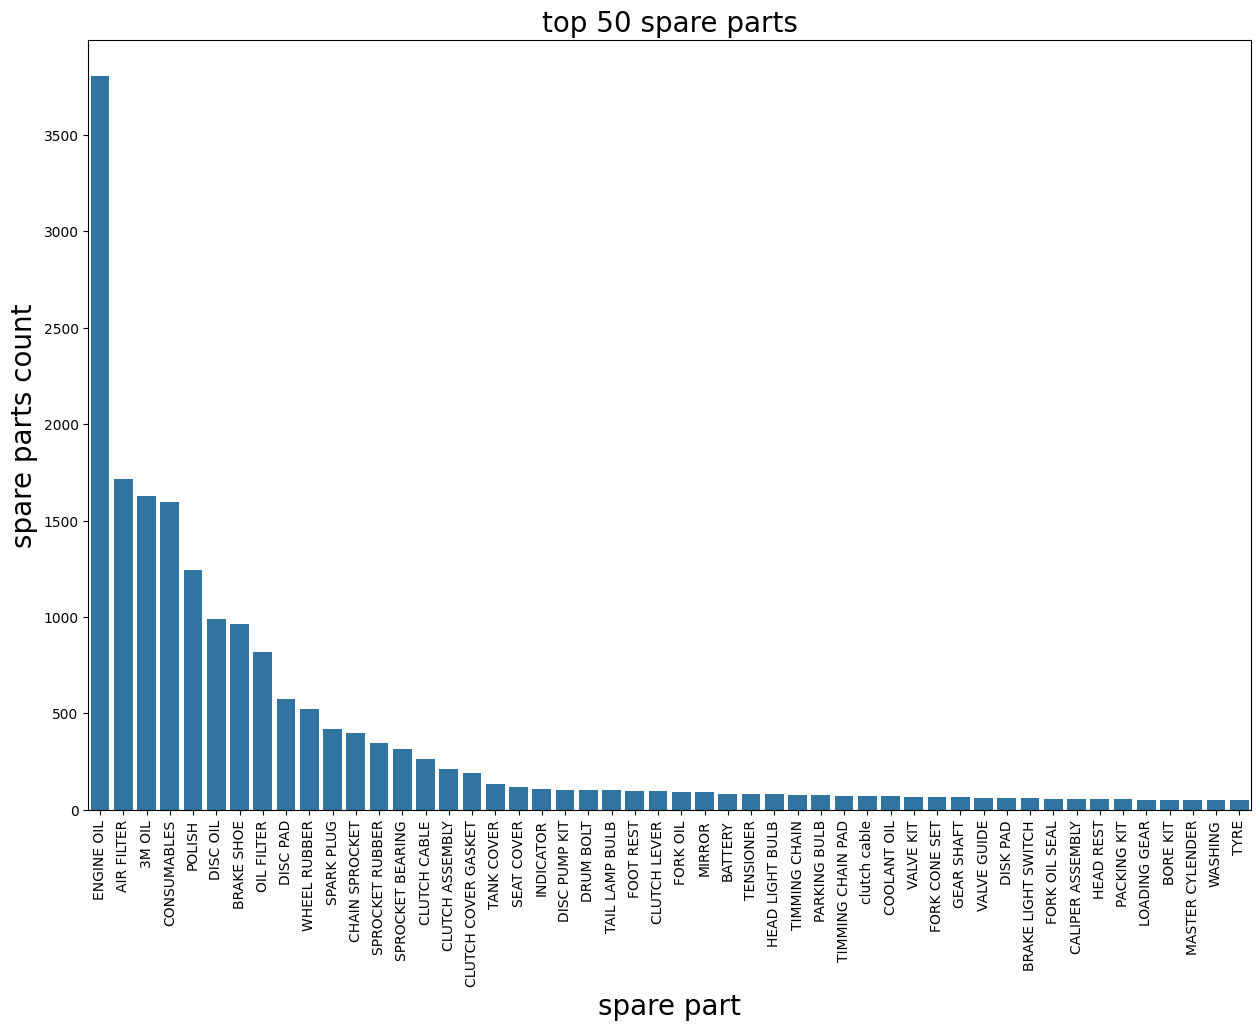

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=data, x='spare_part',
              order=data['spare_part'].value_counts().index[:50],
              ax=ax)
ax.set_title('top 50 spare parts', fontsize=20)
ax.set_ylabel('spare parts count', fontsize=20)
ax.set_xlabel('spare part', fontsize=20)
ax.tick_params(axis='x', rotation=90)
plt.show()

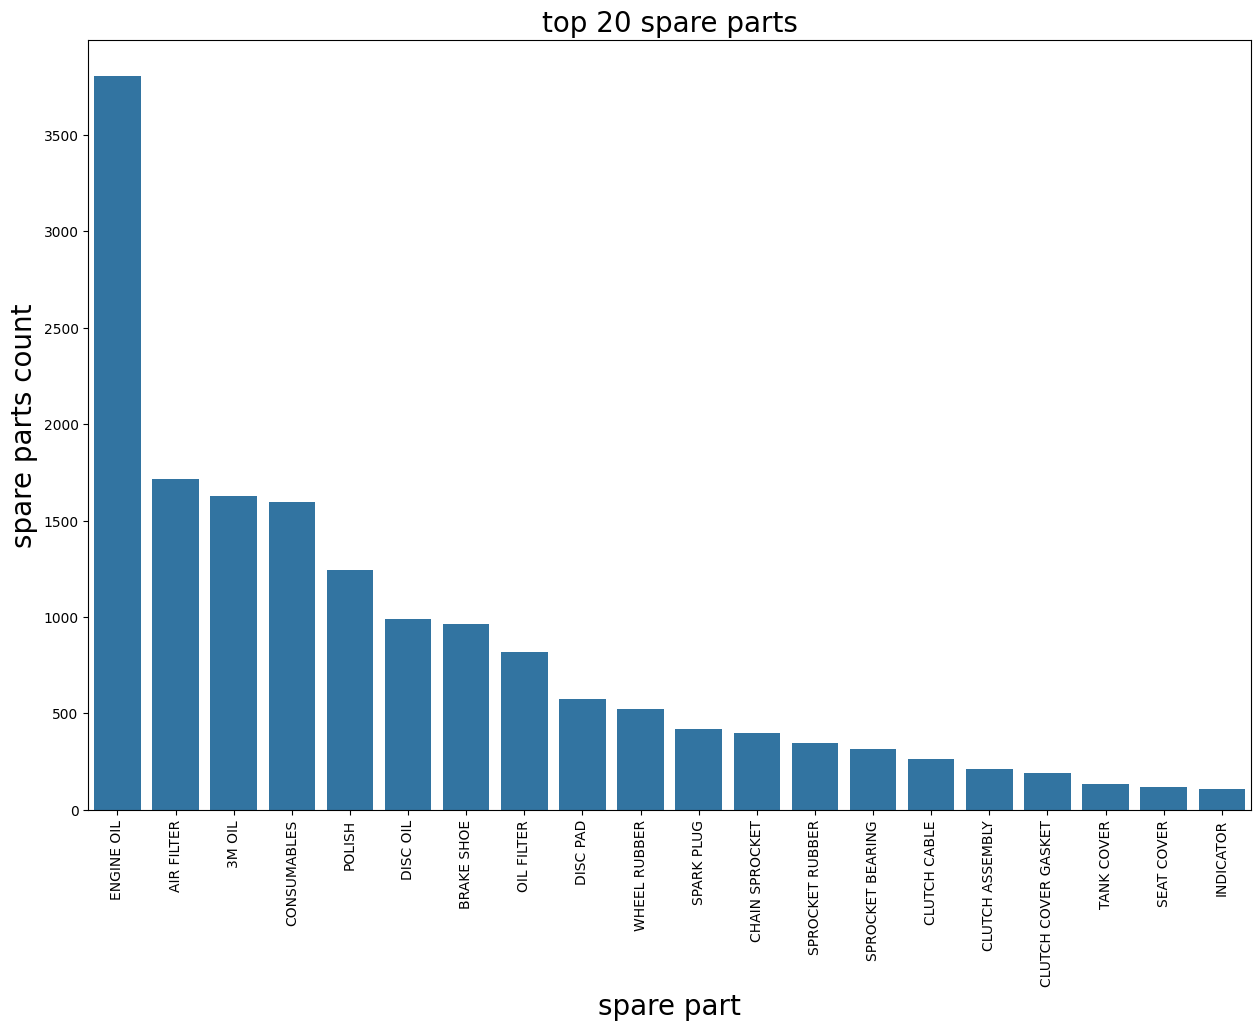

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=data, x='spare_part',
              order=data['spare_part'].value_counts().index[:20],
              ax=ax)
ax.set_title('top 20 spare parts', fontsize=20)
ax.set_ylabel('spare parts count', fontsize=20)
ax.set_xlabel('spare part', fontsize=20)
ax.tick_params(axis='x', rotation=90)
plt.show()

In [36]:
# grouping by vehicle_model
vm_grouped_data = data.groupby(['vehicle_model'])['spare_part'].count().reset_index()
vm_grouped_data.rename(columns={'spare_part': 'count'}, inplace=True)
vm_grouped_data = vm_grouped_data.sort_values(by='count', ascending=False)
vm_grouped_data

,vehicle_model,count
12,BAJAJ PULSAR 150,6480
2,BAJAJ AVENGER STREET 220,3058
14,BAJAJ PULSAR 220,1984
18,BAJAJ PULSAR NS 200,1705
13,BAJAJ PULSAR 180,1703
5,BAJAJ CT 100,1119
7,BAJAJ DISCOVER 125,1027
0,BAJAJ AVENGER STREET,767
11,BAJAJ PLATINA,661
23,BAJAJ V150,523


In [37]:
# grouping by spare part
sp_grouped_data = data.groupby(['spare_part'])['vehicle_model'].count().reset_index()
sp_grouped_data.rename(columns={'vehicle_model': 'count'}, inplace=True)
sp_grouped_data = sp_grouped_data.sort_values(by='count', ascending=False)
sp_grouped_data

,spare_part,count
127,ENGINE OIL,3804
9,AIR FILTER,1713
2,3M OIL,1628
90,CONSUMABLES,1595
298,POLISH,1245
...,...,...
232,LEVER BOLT,1
233,LEVER RUBBER,1
236,LIGHTING COIL,1
243,MAGNET ASSEMBLY,1


In [38]:
data.date.nunique()

553

In [39]:
sp_grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 127 to 430
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   spare_part  431 non-null    object
 1   count       431 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.1+ KB


In [40]:
sp_grouped_data.shape[0]

431

In [41]:
sp_grouped_data[sp_grouped_data['count']>1].shape[0]

288

In [42]:
sp_grouped_data[sp_grouped_data['count']>10].shape[0]

128

In [43]:
sp_grouped_data[sp_grouped_data['count']>=100].shape[0]

23

In [44]:
# setting date as index column
data_indexed = data.set_index('date')
data_indexed.head()

,vehicle_model,spare_part
date,,
2017-05-30,BAJAJ AVENGER STREET 220,ENGINE OIL
2017-05-31,BAJAJ PULSAR NS 200,ENGINE OIL
2017-05-31,BAJAJ PULSAR NS 200,POLISH
2017-05-31,BAJAJ PULSAR NS 200,CONSUMABLES
2017-05-31,BAJAJ PULSAR NS 200,COOLANT OIL


In [45]:
# resampling
weekly_data_indexed = data_indexed[['spare_part']].resample('W').count()
weekly_data_indexed.shape

(84, 1)

In [46]:
weekly_data_indexed.head()

,spare_part
date,
2017-06-04,116
2017-06-11,237
2017-06-18,252
2017-06-25,219
2017-07-02,197


<Figure size 1500x1000 with 0 Axes>

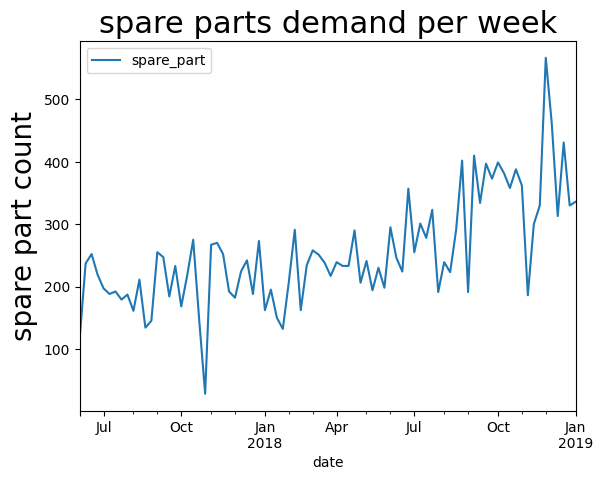

In [47]:
plt.figure(figsize=(15, 10))
weekly_data_indexed.plot()
plt.title('spare parts demand per week', fontsize=22)
plt.ylabel('spare part count', fontsize=20)
plt.show()

## Time Series Analysis

Analyzing the spare parts demand over time.

I will be exploring following statistical techniques over the above data to understand overall pattern and behaviour of the inventory data.

- Time Downsampling
- Moving Average with rolling window
- Cummulative mean with expanding window
- Exponential Weighted Moving Average
- Time series stationarity

### Time Downsampling

In above, I resampled data for weekly, now I will resample it for monthly to get an insight in monthly analysis

In [48]:
monthly_data_indexed = weekly_data_indexed.resample('M').sum()

monthly_data_indexed.head()

,spare_part
date,
2017-06-30,824
2017-07-31,943
2017-08-31,651
2017-09-30,919
2017-10-31,836


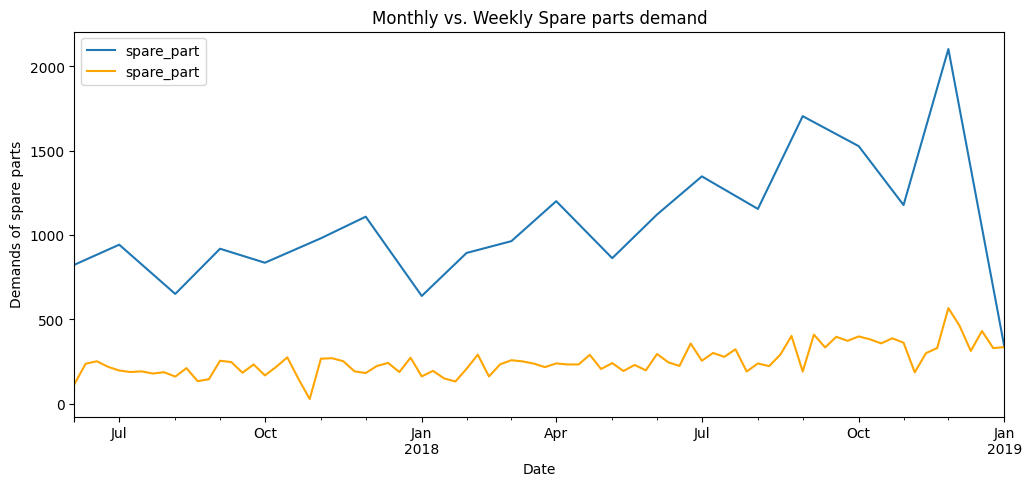

In [49]:
# ploting the weekly demand and monthly demand on same view

fig, ax = plt.subplots(figsize=(12, 5))
# Plot the down sampled
monthly_data_indexed.plot(ax=ax, label='Monthly Demand')

# Plot the upsampled data
weekly_data_indexed.plot(ax=ax, label='Weekly Demand', color='orange')

ax.set_xlabel('Date')
ax.set_ylabel('Demands of spare parts')
ax.set_title('Monthly vs. Weekly Spare parts demand')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

The monthly demands seems less fluctuating.

### Moving Average rolling window

Now I will apply some smoothing techniques to understand overall behaviour of the data.

In [50]:
weekly_data_indexed.columns

Index(['spare_part'], dtype='object')

In [51]:
# defining window size of 4 weeks -> Monthly window
window = 4
weekly_data_indexed['4W_MA'] = weekly_data_indexed['spare_part'].rolling(window).mean()

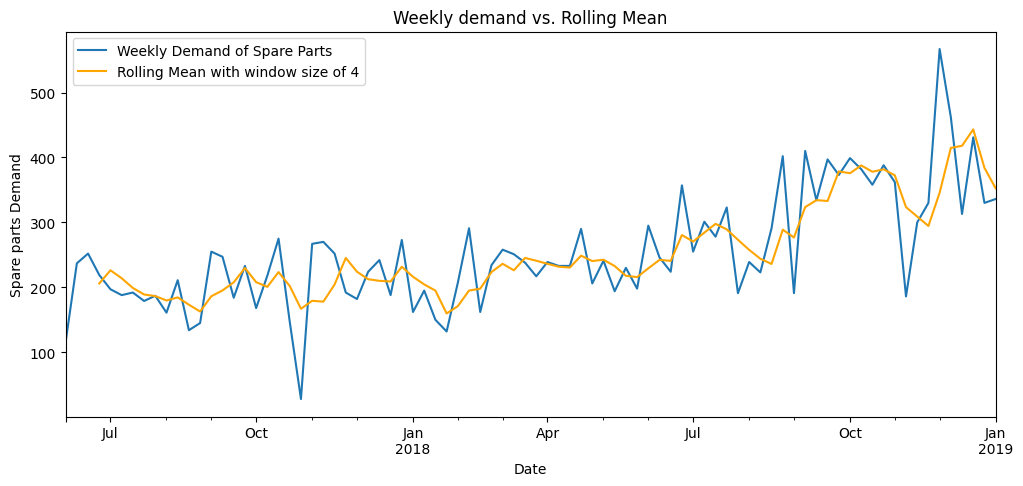

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))
# weekly demand
weekly_data_indexed['spare_part'].plot(ax=ax, label='Weekly Demand of Spare Parts')

# MA with window size 4
weekly_data_indexed['4W_MA'].plot(ax=ax, label='Rolling Mean with window size of 4', color='orange')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Spare parts Demand')
ax.set_title('Weekly demand vs. Rolling Mean')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
plt.show()

### Cumulative mean with expanding window

This is typically used for understanding trends and pattern in the data over time. So, we will plot this also

In [53]:
# Appending cummulative mean over min period = 4 weeks
weekly_data_indexed['4W_CM'] = weekly_data_indexed['spare_part'].expanding(min_periods=4).mean()
weekly_data_indexed.head(10)

,spare_part,4W_MA,4W_CM
date,,,
2017-06-04,116,NaN,NaN
2017-06-11,237,NaN,NaN
2017-06-18,252,NaN,NaN
2017-06-25,219,206.00,206.000000
2017-07-02,197,226.25,204.200000
2017-07-09,188,214.00,201.500000
2017-07-16,192,199.00,200.142857
2017-07-23,179,189.00,197.500000
2017-07-30,187,186.50,196.333333


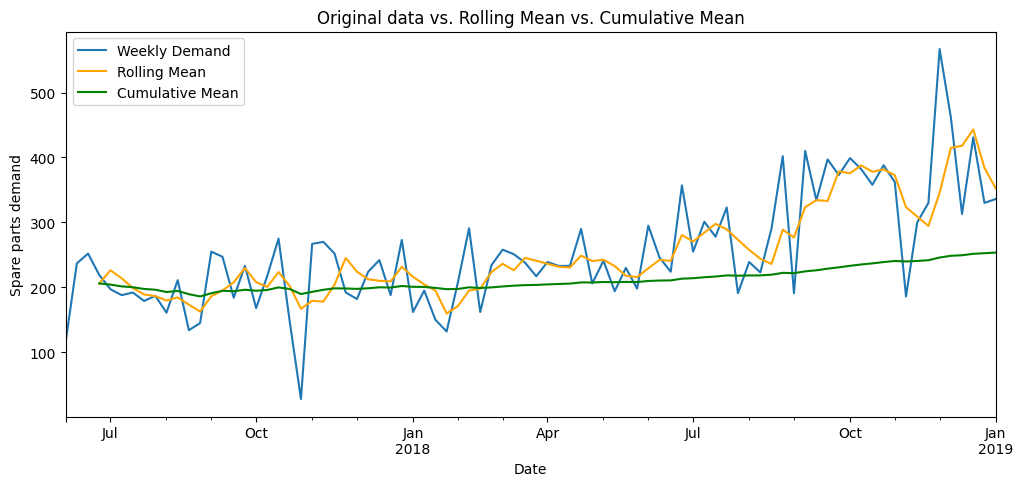

In [54]:
# Ploting the final df
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the data
weekly_data_indexed['spare_part'].plot(ax=ax, label='Weekly Demand')

# Plot the rolling mean
weekly_data_indexed['4W_MA'].plot(ax=ax, label='Rolling Mean', color='orange')

# Plot the cumulative mean
weekly_data_indexed['4W_CM'].plot(ax=ax, label='Cumulative Mean', color='green')

ax.set_xlabel('Date')
ax.set_ylabel('Spare parts demand')
ax.set_title('Original data vs. Rolling Mean vs. Cumulative Mean')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
plt.show()

Cumulative means seems somewhat stationary over time. But let's investigate it a bit more

### Time Series Stationarity

A time series is stationary if the mean and variance are fixed between two equidistance points.

Most the models like ARIMA and it's submodels need the stationary time series data.

Let's check if our data has some trend/seasonality or it is stationary. For stationarity check we can conduct augmented dickey fuller test.


In [55]:
from statsmodels.tsa.stattools import adfuller

In [56]:
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(weekly_data_indexed['spare_part'], autolag='AIC')

# covert into dataframe
dfout = pd.Series(dftest[0:4], index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Airline Data
ADF test statistic      -1.173080
p-value                  0.685068
# lags used              4.000000
# observations          79.000000
critical value (1%)     -3.515977
critical value (5%)     -2.898886
critical value (10%)    -2.586694
dtype: float64


Here we have a very high p-value at 0.68, which provides weak evidence against the null hypothesis, and so we <em>fail to reject</em> the null hypothesis, and decide that our dataset is not stationary.

#### Differencing

Since we will require to make TS stationary, we can do so by differencing.

We can use first order of differencing to make it stationary.

In [57]:
from statsmodels.tsa.statespace.tools import diff

weekly_data_indexed['spare_part_diff'] = diff(weekly_data_indexed['spare_part'], k_diff=1)

weekly_data_indexed.head(5)

,spare_part,4W_MA,4W_CM,spare_part_diff
date,,,,
2017-06-04,116,NaN,NaN,NaN
2017-06-11,237,NaN,NaN,121.0
2017-06-18,252,NaN,NaN,15.0
2017-06-25,219,206.00,206.0,-33.0
2017-07-02,197,226.25,204.2,-22.0


In [58]:
weekly_data_indexed = weekly_data_indexed[['spare_part', 'spare_part_diff']]

In [59]:
weekly_data_indexed.head()

,spare_part,spare_part_diff
date,,
2017-06-04,116,NaN
2017-06-11,237,121.0
2017-06-18,252,15.0
2017-06-25,219,-33.0
2017-07-02,197,-22.0


<Axes: title={'center': 'First order differencing'}, xlabel='date'>

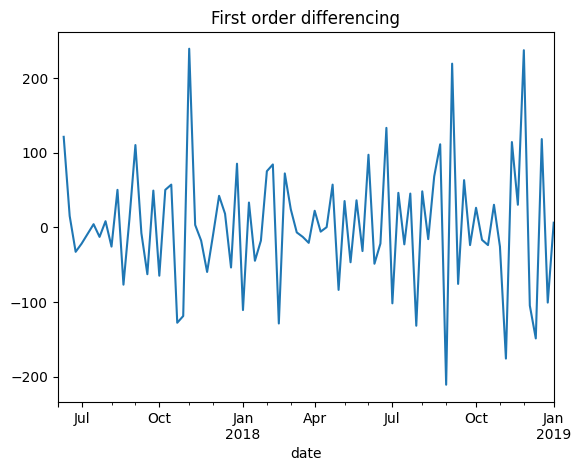

In [60]:
weekly_data_indexed['spare_part_diff'].plot(title="First order differencing")

Now, lets check for stationarity.

In [61]:
# Drop first NaN entry
weekly_data_indexed = weekly_data_indexed.dropna()

In [62]:
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(weekly_data_indexed['spare_part_diff'], autolag='AIC')

# Covert into dataframe
dfout = pd.Series(dftest[0:4], index=['ADF test statistic','p-value','# lags used','# observations'])


for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Airline Data
ADF test statistic     -7.704757e+00
p-value                 1.310568e-11
# lags used             3.000000e+00
# observations          7.900000e+01
critical value (1%)    -3.515977e+00
critical value (5%)    -2.898886e+00
critical value (10%)   -2.586694e+00
dtype: float64


After first order differencing, the series seems stationarity now. The resultant series has `p-value` less than `5%`. So we can procced with this now.

## Time Series Forecasting

Since we are done with Analysis of our data. We also checked for stationarity and then we introduced first order differencing to make the time series stationary.

We can now move ahead for modeling and forecasting for future dates.

We have a lot of options while doing model selection like we can use Auto Regression(AR), Autoregressive Moving Average(ARMA) or Autoregressive Integreted Moving Average(ARIMA).

For time being I will be using Triple Exponential Smoothing for setting the base line and then SARIMA model to get better result.



### Train/Test Split

I am dividing the whole data into test and train such that test data has last 16 weeks points i.e last 2 months.

In [63]:
X = weekly_data_indexed

# Calculate the split point based on an 80:20 ratio
split_point = 16

# Split the data into train and test sets
train_data = X[:-split_point]
test_data = X[-split_point:]

print('Train data length:', len(train_data))
print('Test data length:', len(test_data))

Train data length: 67
Test data length: 16


### Forecasting with Holt's-Winter method


This method is another name of Triple Exponential Smoothing. It takes seasonality into account. When we expect regular fluctuations in the future, this model attempts to map the seasonal behavior.

#### Fitting the model

In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['spare_part'], trend='mul', seasonal='add', seasonal_periods=26).fit()

### Evaluating against test set


In [65]:
test_predictions = fitted_model.forecast(len(test_data))

In [66]:
test_predictions

2018-09-23    321.750006
2018-09-30    304.314863
2018-10-07    328.743871
2018-10-14    360.546873
2018-10-21    329.852402
2018-10-28    229.991413
2018-11-04    367.319000
2018-11-11    349.216064
2018-11-18    363.215633
2018-11-25    321.417872
2018-12-02    368.967820
2018-12-09    378.914862
2018-12-16    386.534845
2018-12-23    410.111611
2018-12-30    397.696225
2019-01-06    378.432220
Freq: W-SUN, dtype: float64

#### Plot test and train data

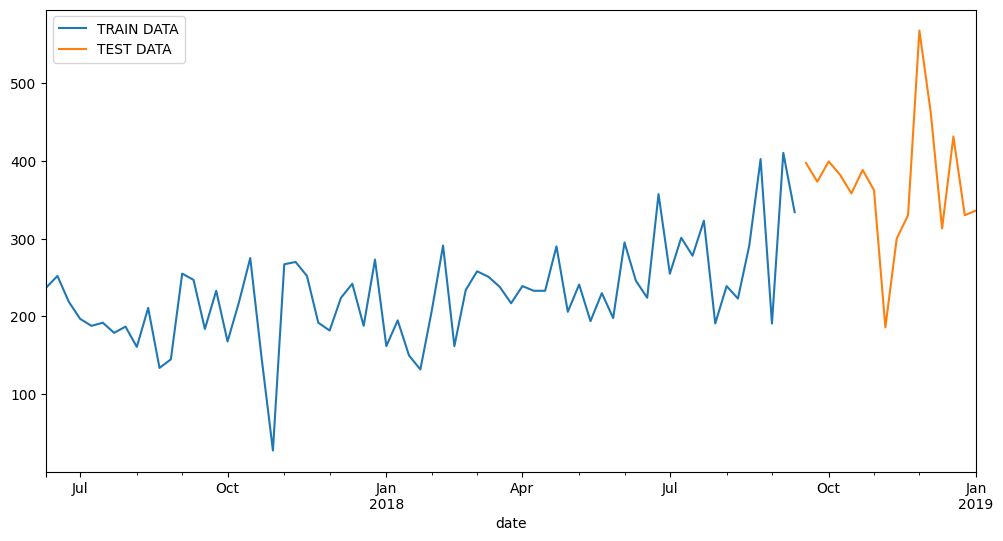

In [67]:
train_data['spare_part'].plot(legend=True, label='TRAIN DATA')
test_data['spare_part'].plot(legend=True, label='TEST DATA', figsize=(12, 6)).autoscale(axis='x', tight=True)

### Plot Actual vs Predicted values

<Axes: xlabel='date'>

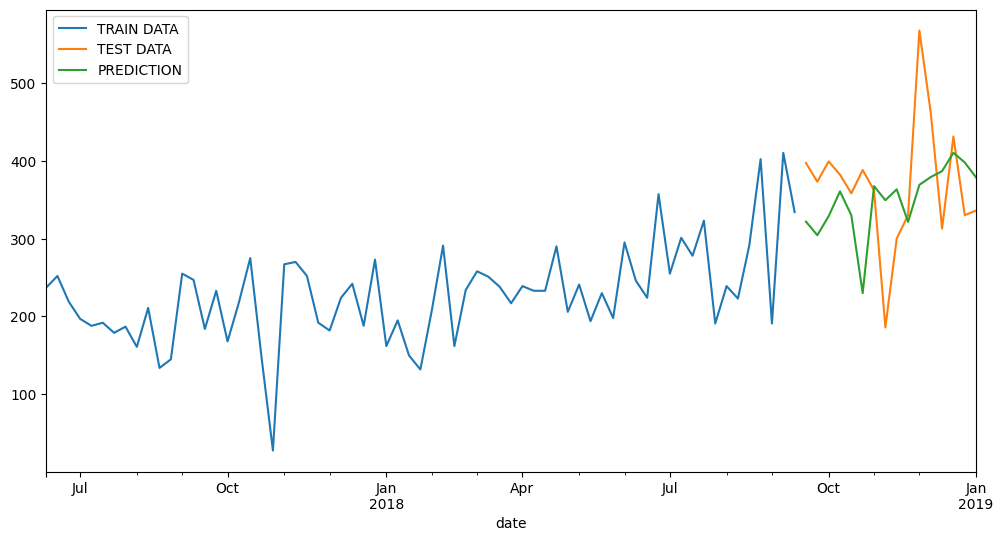

In [68]:
train_data['spare_part'].plot(legend=True, label='TRAIN DATA')
test_data['spare_part'].plot(legend=True, label='TEST DATA', figsize=(12, 6)).autoscale(axis='x', tight=True)
test_predictions.plot(legend=True, label='PREDICTION')

### Evalution Metrics

Since this is a type of regression problem we can use regression metrics like MSE, RMSE or MAE

In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [70]:
mae_error = mean_absolute_error(test_data['spare_part'], test_predictions)

print(f"Mean absolute error of the above model is {mae_error}")

Mean absolute error of the above model is 71.73764953697403


In [71]:
mse_error = mean_squared_error(test_data['spare_part'], test_predictions)

print(f"Mean squared error of the above model is {mse_error}")

Mean squared error of the above model is 8163.741869860507



### Seasonal Autoregressive Integreted Moving Average(SARIMA)


It's an extension of the ARIMA model that includes additional components to capture seasonality in time series data. SARIMA models are particularly useful for analyzing and forecasting data with recurring patterns that repeat over fixed intervals.

#### Decomposition

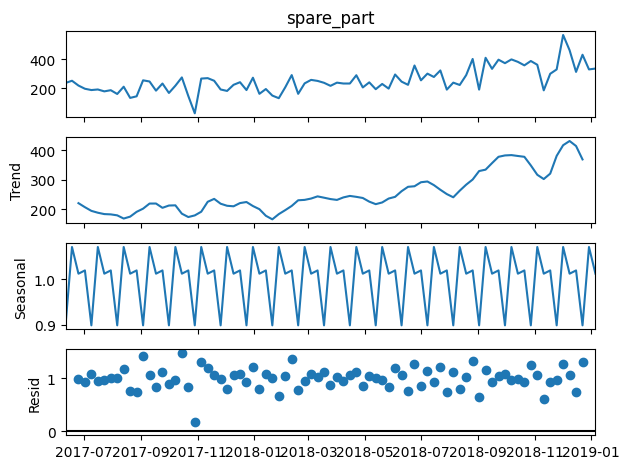

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(weekly_data_indexed['spare_part'], model='mul', period=4)
result.plot();

In [73]:
max(result.seasonal), min(result.seasonal)

(1.0707335507260987, 0.898151724320523)

The apmplitude of the sesonality curve seems too low, so we can ignore the sesonality in the time series.

#### Selecting SARIMA orders

For getting optimal values of SARIMA orders i.e (p, d, q)X(P, D, Q) we can use heuristic search or we can also use some third party library for it.

In [75]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00


In [76]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

In [77]:
auto_arima(train_data['spare_part'], seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   67
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 12)   Log Likelihood                -357.921
Date:                             Sun, 19 May 2024   AIC                            733.842
Time:                                     04:05:28   BIC                            753.549
Sample:                                 06-11-2017   HQIC                           741.629
                                      - 09-16-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3683      1.157      1.183      0.237      -0.899       3.636
ar.L1         -0.0577      0.164     -0.351      0.725      -0.379       0.264
ar.L2         -0.0969      0.173     -0.561      0.575      -0.435       0.242
ar.L3          0.0510      0.173      0.294      0.769      -0.289       0.391
ar.L4         -0.0510      0.178     -0.286      0.775      -0.400       0.298
ar.L5          0.0531      0.179      0.297      0.766      -0.297       0.403
ma.L1         -0.9880      0.308     -3.210      0.001      -1.591      -0.385
ar.S.L12       0.2164      0.165      1.314      0.189      -0.106       0.539
sigma2      2842.6003    742.129      3.830      0.000    1388.055    4297.146
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.76
Prob(Q):                              0.87   Prob(JB):                         0.15
Heteroskedasticity (H):               1.22   Skew:                             0.05
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We need to check combination leads to minimum AIC score. Based on this score we can decide the final order of our model.

#### Fitting the model

In [78]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

In [79]:
model = SARIMAX(train_data['spare_part'],order=(5,1,1), seasonal_order=(1, 0, 0, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          spare_part   No. Observations:                   67
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 12)   Log Likelihood                -359.625
Date:                             Sun, 19 May 2024   AIC                            735.250
Time:                                     04:05:47   BIC                            752.767
Sample:                                 06-11-2017   HQIC                           742.172
                                      - 09-16-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1307      0.261     -0.502      0.616      -0.641       0.380
ar.L2         -0.1479      0.241     -0.613      0.540      -0.621       0.325
ar.L3          0.0067      0.247      0.027      0.978      -0.477       0.491
ar.L4         -0.0720      0.212     -0.340      0.734      -0.487       0.343
ar.L5          0.0415      0.223      0.186      0.853      -0.396       0.479
ma.L1         -0.8333      0.214     -3.902      0.000      -1.252      -0.415
ar.S.L12       0.2224      0.179      1.240      0.215      -0.129       0.574
sigma2      3060.7657    521.074      5.874      0.000    2039.480    4082.051
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.86   Prob(JB):                         0.63
Heteroskedasticity (H):               1.33   Skew:                            -0.03
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
# Obtain predicted values
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')

In [81]:
# Comparing predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test_data['spare_part'][i]}")

predicted=266.388467 , expected=397
predicted=317.7097214, expected=373
predicted=288.7464433, expected=399
predicted=312.3835184, expected=382
predicted=283.8946753, expected=358
predicted=287.4628656, expected=388
predicted=288.2153936, expected=362
predicted=301.8649572, expected=186
predicted=326.5662752, expected=300
predicted=280.4248042, expected=330
predicted=328.4191543, expected=567
predicted=311.7755702, expected=462
predicted=296.7515572, expected=313
predicted=308.0652506, expected=431
predicted=301.7201939, expected=330
predicted=306.9318002, expected=336


#### Plot the predictions

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Weekly Demand')]

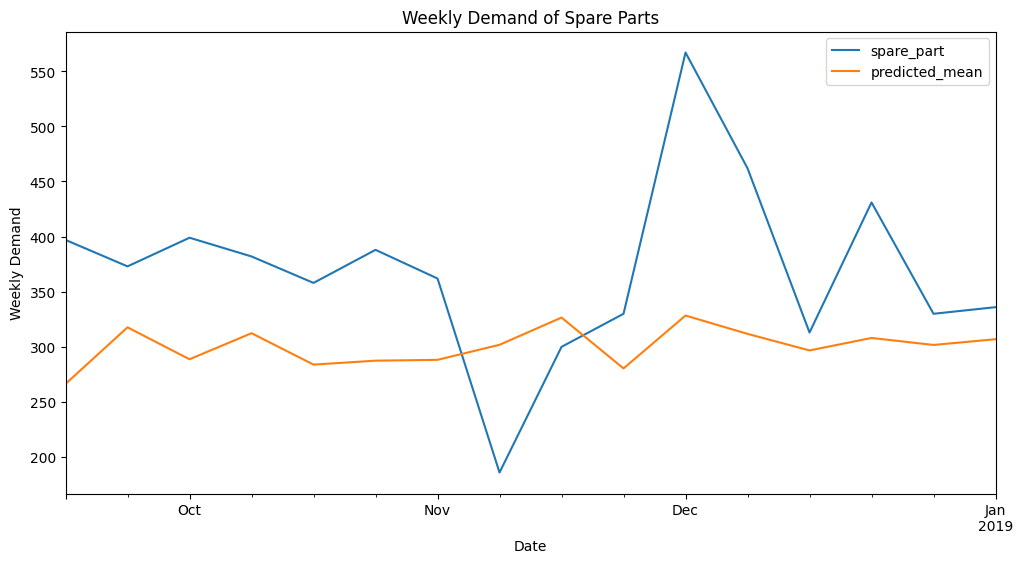

In [82]:
# Ploting the predictions against known values
title = 'Weekly Demand of Spare Parts'
ylabel='Weekly Demand'
xlabel='Date'

ax = test_data['spare_part'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### Model's Evaluation

To evaluate the model's performance let's see how the model is performing on the test set that we splitted out from whole dataset.

We can forcast for test points and the we can plot the actual test points and compare the model predictions visually and using some regression metrics.

In [83]:
from sklearn.metrics import mean_squared_error


error = mean_squared_error(test_data['spare_part'], predictions)
print(f'SARIMA(2,0,1,12) MSE Error: {error:11.10}')

SARIMA(2,0,1,12) MSE Error: 10703.76238


#### Forecast for next 16 weeks

So far we splitted the dataset into train and test set. We fitted our SARIMA model over train data and evaluated the performance on test data.

Now we can use the same strategy to forecast for future points. We can train the model on all data and then forecast the values for future points.



In [84]:
model = SARIMAX(weekly_data_indexed['spare_part'],order=(5,1,1), seasonal_order=(1, 0, 0, 12))

results = model.fit()
fcast = results.predict(len(weekly_data_indexed),len(weekly_data_indexed)+15,typ='levels').rename('SARIMA(5,1,1)(1,0,0,12) Forecast')

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Weekly Demand')]

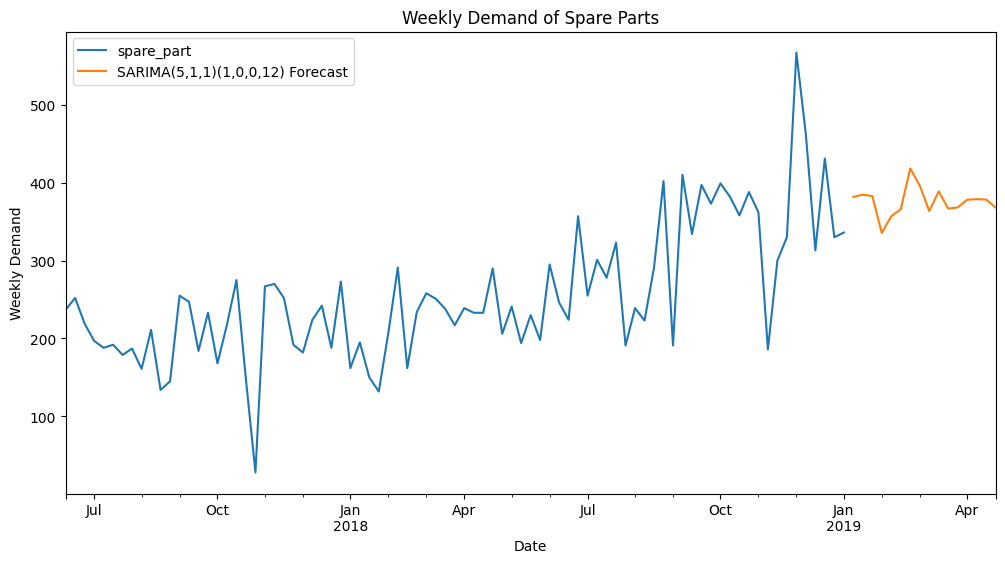

In [85]:
# Ploting the predictions against known values
title = 'Weekly Demand of Spare Parts'
ylabel='Weekly Demand'
xlabel='Date'

ax = weekly_data_indexed['spare_part'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

So far we analyzed the data in univariate fashion like we aggregated the spare parts count from the inventory data irrespective of the two wheeler models.

We assumed the the count of spare parts required for each model will be same and it does not depend on model of that bike.

Now we can explore the multivariate analysis where we also induct the two wheelers model into account.


## Induct eXogenous variable in SARIMAX model


Transform the dataset such that for each date we have distinct number of bikes and the spare parts count. It seems like if you have more number of bikes you will need to have more spare parts count.

In [91]:
# will do this in free time